# Import photos

In [6]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
#from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet20, densenet
from keras.applications import nasnet, resnet20, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

%matplotlib inline

ImportError: cannot import name 'resnet20' from 'tensorflow.keras.applications' (/opt/anaconda3/lib/python3.11/site-packages/keras/_tf_keras/keras/applications/__init__.py)

In [4]:
base_dir = 'data_3'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training infected Cicada pictures
train_1_dir = os.path.join(train_dir, '1')

# Directory with our training normal Cicada pictures
train_0_dir = os.path.join(train_dir, '0')

# Directory with our validation infected Cicada pictures
validation_1_dir = os.path.join(validation_dir, '1')

# Directory with our validation normal Cicada pictures
validation_0_dir = os.path.join(validation_dir, '0')

# Directory with our test infected Cicada pictures
test_1_dir = os.path.join(test_dir, '1')

# Directory with our test normal Cicada pictures
test_0_dir = os.path.join(test_dir, '0')

In [ ]:
#Set up matplotlib fig, and size it to fit 4x4 pics

import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_1_fnames = os.listdir( train_1_dir )
train_0_fnames = os.listdir( train_0_dir )


next_1_pix = [os.path.join(train_1_dir, fname) 
                for fname in train_1_fnames[ pic_index-8:pic_index] 
               ]

next_0_pix = [os.path.join(train_0_dir, fname) 
                for fname in train_0_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_1_pix+next_0_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# ResNet20

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = validation_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

test_generator = test_datagen.flow_from_directory( test_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

NameError: name 'train_dir' is not defined

In [5]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

TypeError: The added layer must be an instance of class Layer. Found: <Functional name=resnet50, built=True>

In [12]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

ValueError: Argument(s) not recognized: {'lr': 0.0001}

In [248]:
#resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)
resnet_history = base_model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=5)

Epoch 1/5
50/50 [==============================] - 231s 5s/step - loss: 2.2161 - acc: 0.5640 - val_loss: 1.2786 - val_acc: 0.5835
Epoch 2/5
50/50 [==============================] - 221s 4s/step - loss: 1.2028 - acc: 0.6960 - val_loss: 1.9190 - val_acc: 0.5835
Epoch 3/5
50/50 [==============================] - 230s 5s/step - loss: 0.8826 - acc: 0.7690 - val_loss: 3.1568 - val_acc: 0.5835
Epoch 4/5
50/50 [==============================] - 222s 4s/step - loss: 0.7564 - acc: 0.8170 - val_loss: 3.8873 - val_acc: 0.5835
Epoch 5/5
50/50 [==============================] - 218s 4s/step - loss: 0.6528 - acc: 0.8310 - val_loss: 3.6911 - val_acc: 0.5835


In [249]:
resnet_history.model.evaluate(test_generator)

27/27 [==============================] - 29s 1s/step - loss: 8.0601 - acc: 0.0815


[8.06011962890625, 0.08148147910833359]

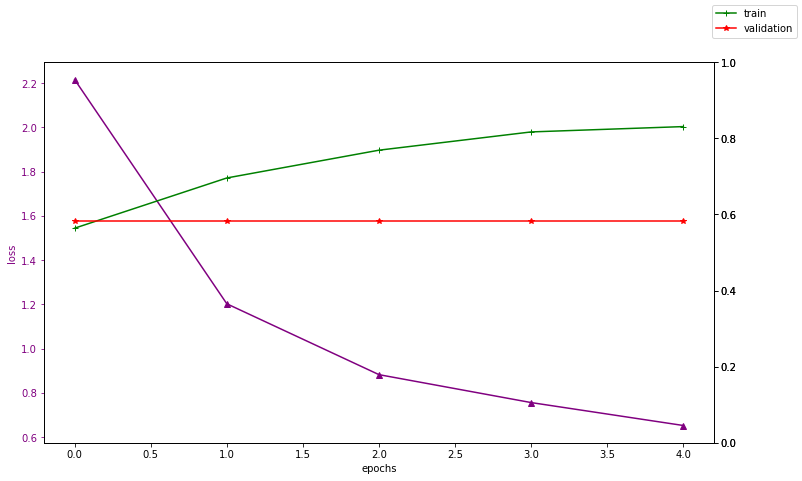

In [250]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(resnet_history.epoch, resnet_history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(resnet_history.epoch, resnet_history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(resnet_history.epoch, resnet_history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)


fig.legend();

In [ ]:
res

In [179]:
resnet_history = resnet_history.model.fit(test_generator,verbose=1, epochs=5)

Epoch 1/5
48/48 [==============================] - 200s 4s/step - loss: 0.5071 - acc: 0.8638
Epoch 2/5
48/48 [==============================] - 186s 4s/step - loss: 0.3203 - acc: 0.9113
Epoch 3/5
48/48 [==============================] - 184s 4s/step - loss: 0.2252 - acc: 0.9388
Epoch 4/5
48/48 [==============================] - 186s 4s/step - loss: 0.1629 - acc: 0.9461
Epoch 5/5
48/48 [==============================] - 184s 4s/step - loss: 0.1163 - acc: 0.9578


In [251]:
#1.Predict classes
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = resnet_history.model.predict(test_generator)

# Get most likely class
predicted_classes = [1 * (x[0]>=0.5) for x in predictions]

# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

# 3. Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix,classification_report

print(class_labels)

print(confusion_matrix(test_generator.classes, predicted_classes))

report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

['0', '1']
[[  0 496]
 [  0  44]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       496
           1       0.08      1.00      0.15        44

    accuracy                           0.08       540
   macro avg       0.04      0.50      0.08       540
weighted avg       0.01      0.08      0.01       540



/Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
